In [1]:
import os
from glob import glob
import nibabel as nib
from scipy.spatial.distance import dice
import numpy as np
import itk
import SimpleITK as sitk
import scipy.ndimage
import scipy
import matplotlib.pyplot as plt
import pandas as pd
from nilearn.reporting import make_glm_report
from nilearn.glm.second_level import SecondLevelModel
from nilearn import plotting
from nilearn.glm import threshold_stats_img

In [2]:
from nilearn.plotting import plot_design_matrix
mouses_filename = os.path.join('dataset3', 'GIN', 'gin.csv')
mouses_csv = pd.read_csv(mouses_filename)
svbp = mouses_csv['study'] == 'SVBP'
map6 = mouses_csv['study'] == 'MAP6'
wt = mouses_csv['type'] == 'WT'
ko = mouses_csv['type'] == 'KO'
svbp_wt = svbp * wt
svbp_ko = svbp * ko
map6_wt = map6 * wt
map6_ko = map6 * ko

27


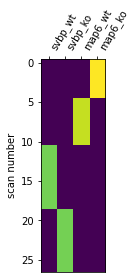

In [3]:
design_matrix = pd.DataFrame(np.vstack((svbp_wt, svbp_ko, map6_wt, map6_ko)).T,
                             columns=['svbp_wt', 'svbp_ko', 'map6_wt', 'map6_ko'])
ax = plot_design_matrix(design_matrix)
print(len(design_matrix))

output/GIN/ANTS/Log10Jacobian_Deformable/Log10JacobianDeformable_653_N4_deformablewarp.nii.gz


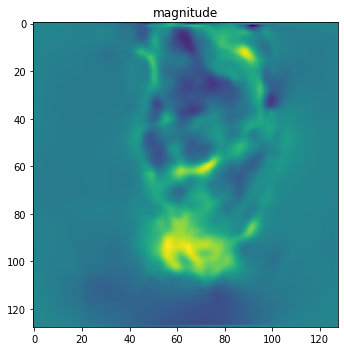

In [4]:
log_filenames = sorted(glob(os.path.join('output', 'GIN', 'ANTS', 'Log10Jacobian_Deformable', "*.nii.gz")))
for file in log_filenames:
    print(file)
    log10 = nib.load(file).get_fdata()    
    i = log10.shape[0]//2
    dat = (log10[i,:,:])
    plt.figure("Jacobian", (12, 6))
    plt.subplot(1, 2, 1)
    plt.title("magnitude")    
    plt.imshow(dat)
    plt.show()
    plt.show()
    break

In [5]:
atlas_mri = os.path.join('dataset3', 'Atlas', 'P56_Atlas_128_norm_id.nii.gz')
mask_img = nib.load(os.path.join('dataset3', 'Atlas', 'P56_Annotation_128_norm_id_mask.nii.gz'))
second_level_model = SecondLevelModel(smoothing_fwhm=4.0, mask_img=mask_img)
second_level_model.fit(log_filenames,
                       design_matrix=design_matrix)

SecondLevelModel(mask_img=<nibabel.nifti1.Nifti1Image object at 0x7f3bc1b69a30>,
                 smoothing_fwhm=4.0)

In [6]:
thresholds_dict = { 
                'fdr005': ('fdr', 0.05),
                'fpr0001': ('fpr', 0.001),  
                'fpr0005': ('fpr', 0.005),
            }
contrasts_dict = {
    #'study'     : [-1, -1, 1, 1],
    #'study-KO'  : [0, -1, 0, 1],
    #'study-WT'  : [-1, 0, 1, 0],
    #'type'      : [-1, 1, -1, 1],
    'type-SVBP' : [-1, 1, 0, 0],
    'type-MAP6' : [0, 0, -1, 1],
}

In [7]:
for heights, values in thresholds_dict.items():
    report = make_glm_report(model=second_level_model,
                             contrasts=contrasts_dict,
                             bg_img=atlas_mri,
                             height_control=values[0],
                             alpha=values[1],
                             display_mode='z',
                             cut_coords=(50,55,60,65,70,75,80),
                             )
    report.save_as_html(os.path.join('output', 'GIN', 'ANTS', 'Reports-Deformable', 'report_deformable_gin_' + str(heights) + '.html'))

The given float value must not exceed 3.051906246309059. But, you have given threshold=inf 
empty mask
The given float value must not exceed 3.051906246309059. But, you have given threshold=inf 
Attention: No clusters with stat higher than inf
The given float value must not exceed 3.051906246309059. But, you have given threshold=3.2905267314918945 
empty mask
The given float value must not exceed 3.051906246309059. But, you have given threshold=3.2905267314918945 
Attention: No clusters with stat higher than 3.2905267314918945


In [9]:
for k,v in contrasts_dict.items(): 
    z_map = second_level_model.compute_contrast(second_level_contrast=v, output_type='z_score')
    nib.save(z_map, os.path.join('output', 'GIN', 'ANTS', 'Reports-Deformable', str(k) + '_' + str(heights) + '_zmap.nii.gz'))
    for heights, values in thresholds_dict.items():
        threshold_mask, threshold = threshold_stats_img(z_map, alpha=values[1], height_control=values[0])    
        nib.save(threshold_mask, os.path.join('output', 'GIN', 'ANTS', 'Reports-Deformable', str(k) + '_' + str(heights) + '.nii.gz'))